# Import Section

In [0]:
# Path
import os

# Timer
import time

# Math
import math

# Data
import numpy as np
from tensorflow.keras.utils import plot_model

# Plot
import matplotlib.pyplot as plt

# Image
from PIL import Image # used in image processing function
from PIL import ImageFilter # used in load_image_pair()

# Tensorflow
import tensorflow as tf

from tensorflow.keras.preprocessing.image import load_img

# For Tensorflow Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.initializers import RandomNormal

# Colab Function

In [0]:
def gpu_check():
  """
    check your gpu is available:
  """
  import torch # we are using tensorflow, I import torch here just becuase torch.device() works better with colab.
  
  # setting device on GPU if available, else CPU
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  print('Using device:', device)
  print()

  #Additional Info when using cuda
  if device.type == 'cuda':
      print(torch.cuda.get_device_name(0))
      print('Memory Usage:')
      print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
      print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

# Path Functions

In [0]:
def ensure_dir(path_to_dir):
  try:
      os.makedirs(path_to_dir)
  except FileExistsError:
      # directory already exists
      pass

# Config

In [0]:
"""
    config project in this cell.
"""

# Env, where you running this project
# Google colab: 'colab'
# local machine: 'local'
# google cloud deep learning VM: 'gcpvm'
env = 'colab'


In [5]:
""" 
     _______________________________________________
    | YOU SHOULD NOT CHANGE ANY THING IN THIS CELL. |
    |_______________________________________________|
"""

# config dictionary
config = {
    'colab':{
        'data_dir':'/content/drive/My Drive/Colab Notebooks/data',
        'checkpoint_dir':'/content/drive/My Drive/Colab Notebooks/checkpoints',
        'log_dir':'/content/drive/My Drive/Colab Notebooks/logs',
        'predict_dir':'/content/drive/My Drive/Colab Notebooks/prediction',
        'result_dir':'/content/drive/My Drive/Colab Notebooks/result',
        'result_demo_dir': '/content/drive/My Drive/Colab Notebooks/result_demo'
    },
    'local':{
        'data_dir': os.path.join(os.getcwd(), 'data'),
        'checkpoint_dir': os.path.join(os.getcwd(), 'checkpoints'),
        'log_dir': os.path.join(os.getcwd(), 'logs'),
        'predict_dir':os.path.join(os.getcwd(), 'prediction'),
        'result_dir':os.path.join(os.getcwd(), 'result'),
        'result_demo_dir': os.path.join(os.getcwd(), 'result_demo'),
    },
    'gcpvm':{
        'data_dir': os.path.join('/home/Weicheng', 'data'),
        'checkpoint_dir': os.path.join('/home/Weicheng/downloads', 'checkpoints'),
        'log_dir': os.path.join('/home/Weicheng/downloads', 'logs'),
        'predict_dir':os.path.join('/home/Weicheng/downloads', 'prediction'),
        'result_dir':os.path.join('/home/Weicheng/downloads', 'result'),
        'result_demo_dir': os.path.join('/home/Weicheng/downloads', 'result_demo'),
    }
}

# setting all variables
data_dir = config[env]['data_dir']
checkpoint_dir = config[env]['checkpoint_dir']
log_dir = config[env]['log_dir']
predict_dir = config[env]['predict_dir']
result_dir = config[env]['result_dir']
result_demo_dir = config[env]['result_demo_dir']

# mount google drive
if env == 'colab':
  # Google Drive
  from google.colab import drive
  # mount google dirve
  drive.mount('/content/drive')
  # check GPU
  # gpu_check()
  
# make sure dir exist
ensure_dir(checkpoint_dir)
ensure_dir(log_dir)
ensure_dir(predict_dir)
ensure_dir(result_dir)
ensure_dir(result_demo_dir)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Image Processing Function

In [0]:
def bicubic_rescale(image, scale):
  """
      Rescale image using bicubic interpolation.
      
      Args:
        image: image
        scale: use integer for up scaling. use 1/integer for down scaling
  """
  # make sure scale is valid
  if isinstance(scale, (float, int)):
    size = (np.array(image.size) * scale).astype(int)
  return image.resize(size, resample=Image.BICUBIC)


def modcrop(image, scale):
  """
      To scale down the original image, there must be no remainder while scaling
      operation.
      
      All we want to do in here is to subtract the remainder from height and 
      width of original image size, and cut the original image to the new size.
      
      Args:
        image: original image
        scale: must be int
  """
  if not isinstance(scale, int):
    raise Exception('Image Processing Function.modcrop: scale must be int')
  size = np.array(image.size)
  size -= size % scale
  return image.crop([0, 0, *size])

def centercrop(image, size):
  """
      To crop the image from center.
      
      Args:
        size: the size of image after crop, Size for both height and width.
  """
  width, height = image.size

  left = (width - size)/2
  top = (height - size)/2
  right = (width + size)/2
  bottom = (height + size)/2
  
  if not all(isinstance(i, int) for i in [left, top, right, bottom]):
    if not all(int(i) == i for i in [left, top, right, bottom]):
      raise Exception('Image Processing Function.centercrop: with this size, image can not precisely crop at the center')

  return image.crop([left, top, right, bottom])

# Data Preprocessing

In [0]:
def img_to_array(img):
  """
    convert image to array using tensorflow.keras.preprocessing.image.img_to_array, then normalized data to range(0, 1).
  """
  array = tf.keras.preprocessing.image.img_to_array(img)
  return array/255


def array_to_img(array):
  """
    scale a array to range(0, 255), then convert array to image using tensorflow.keras.preprocessing.image.array_to_img.
  """
  array = array*255
  # make any number smaller than 0 to be 0 and any number bigger than 255 to be 255
  np.clip(array, 0, 255)
  return tf.keras.preprocessing.image.array_to_img(array)
  


def load_image_pair(path, scale=3, greyscale=False, same_size=False):
  """
      Down scaling a hight resolution image to a low resolution image and
      return both of them.
      
      Args:
        path: image path
        scale: scale of down scaling, must be a int
        greyscale: return only Y channel
  """
  image = load_img(path)
  
  if greyscale:
    image = image.convert('YCbCr')
    Y, Cb, Cr = image.split()
    image = Y
  else:
    image = image.convert('RGB')

  hr_image = modcrop(image, scale)
#  lr_image = hr_image.filter(ImageFilter.GaussianBlur(radius=2))
  lr_image = bicubic_rescale(hr_image, 1 / scale)
  if same_size:
    lr_image = bicubic_rescale(lr_image, scale)
  return lr_image, hr_image


# def random_crop(lr_image, hr_image, random_crop_size):
#   """
#       randomly crop both lr and hr image at the same position.
      
#       Args:
#           random_crop_size: size of sub image, array, example:[32,32]
#   """
#   # Note: image_data_format is 'channel_last'
#   height, width = lr_image.size
#   dy, dx = random_crop_size
#   x = np.random.randint(0, width - dx + 1)
#   y = np.random.randint(0, height - dy + 1)
#   return lr_image.crop([x, y, x + dx, y + dy]), hr_image.crop([x, y, x + dx, y + dy])

def random_crop(image, random_crop_size):
  """
      randomly crop both lr and hr image at the same position.
      
      Args:
          random_crop_size: size of sub image, array, example:[32,32]
  """
  # Note: image_data_format is 'channel_last'
  height, width = image.size
  dy, dx = random_crop_size
  x = np.random.randint(0, width - dx + 1)
  y = np.random.randint(0, height - dy + 1)
  return image.crop([x, y, x + dx, y + dy])


def generate_sub_images(image, size, stride):
  """
      Cut image into sub images.
      
      Args:
        image: image
        size: size of sub image
        stride: distance of how much the window shifts by in each of the 
                dimensions
  """
  for i in range(0, image.size[0] - size + 1, stride):
        for j in range(0, image.size[1] - size + 1, stride):
            # yield return a generator, or a list of number
            yield image.crop([i, j, i + size, j + size])
            
            
class Dataset:
  
  def __init__(self):
    self.lr_sub_size = 0
    self.lr_sub_stride = 0
    self.hr_sub_size = 0
    self.hr_sub_stride = 0
    self.lr_images = []
    self.hr_images = []
    self.greyscale = False
    self.same_size = False
    
    
  def load_set(self, dataset_name, same_size, greyscale=False):
    """
        Load all image from a directory.

        Args:
          dataset_name: name of dir of the data set
          lr_sub_size: low resolution sub image size
          lr_sub_stride: stride when crop sub image
          scale: down scale value
          same_size: hr, lr have the same size
          greyscale: return only Y channel
    """
    self.greyscale = greyscale
    self.same_size = same_size
    
    # set up progress bar
    file_num = len([file_name for file_name in os.listdir(os.path.join(data_dir, dataset_name))])
    progress_bar = tf.keras.utils.Progbar(file_num)
    jobs_done = 0
    print('load_set: ')
    
    for file_name in os.listdir(os.path.join(data_dir, dataset_name)):
      path = os.path.join(data_dir, dataset_name, file_name)
      lr_image, hr_image = load_image_pair(str(path), scale=scale, greyscale=self.greyscale, same_size=self.same_size)
      self.lr_images.append(lr_image)
      self.hr_images.append(hr_image)
      progress_bar.update(jobs_done)
      jobs_done += 1
     
    print()
      
      
  def show_set(self):
    """
      view the first 3 image of the dataset
    """
    if self.greyscale:
      colormap = 'gray'
    else:
      colormap = None
      
    f, axarr = plt.subplots(2, 3, figsize=(18,18))
    
    # Plot images in subplot
    axarr[1,2].imshow(self.hr_images[0], cmap=colormap)
    axarr[1,1].imshow(self.hr_images[1], cmap=colormap)
    axarr[1,0].imshow(self.hr_images[2], cmap=colormap)
    axarr[0,2].imshow(self.lr_images[0], cmap=colormap)
    axarr[0,1].imshow(self.lr_images[1], cmap=colormap)
    axarr[0,0].imshow(self.lr_images[2], cmap=colormap)
    
    # Disable axis
    axarr[1,2].axis("off")
    axarr[1,1].axis("off")
    axarr[1,0].axis("off")
    axarr[0,2].axis("off")
    axarr[0,1].axis("off")
    axarr[0,0].axis("off")
   
    plt.show()
    
  def sub_image_set_random(self, lr_sub_size, hr_sub_size, scale, num_of_image=1):
    """
      return the sub image dataset, sub image crop randomly
    """
    lr_sub_arrays = []
    hr_sub_arrays = []
    lr_batch = []
    hr_batch = []
    height, width = self.hr_images[0].size
    dx = lr_sub_size
    dy = lr_sub_size

    # crop low resolution image and high resolution image at same position
    for lr_image, hr_image in zip(self.lr_images, self.hr_images):
      for i in range(num_of_image):
        x = np.random.randint(0, width - dx + 1)
        y = np.random.randint(0, height - dy + 1)

        lr_batch += [lr_image.crop([x, y, x + dx, y + dy])]
        hr_batch += [hr_image.crop([x, y, x + dx, y + dy])]
        
      # crop high resolution image
      if lr_sub_size !=  hr_sub_size:
        for i in range(len(hr_batch)):
          hr_batch[i] = centercrop(hr_batch[i], hr_sub_size)

      lr_sub_arrays += [img_to_array(img) for img in lr_batch]
      hr_sub_arrays += [img_to_array(img) for img in hr_batch]

    # convert list to np.array
    x = np.stack(lr_sub_arrays)
    y = np.stack(hr_sub_arrays)

    return x, y 
    
  
  def sub_image_set(self, lr_sub_size, hr_sub_size, lr_sub_stride, scale):
    """
      return the normalized sub image array dataset, 
    """
    lr_sub_arrays = []
    hr_sub_arrays = []

    # compute parameters for high resolution image
    if self.same_size:
      _hr_sub_size = lr_sub_size
      _hr_sub_stride = lr_sub_stride
    else:
      _hr_sub_size = lr_sub_size * scale
      _hr_sub_stride = lr_sub_stride * scale
      
    # set up progress bar
    file_num = len(self.hr_images)
    progress_bar = tf.keras.utils.Progbar(file_num)
    jobs_done = 0
    print('sub_image_set:')

    for lr_image, hr_image in zip(self.lr_images, self.hr_images):
      # make low resolution sub image set
      lr_sub_arrays += [img_to_array(img) for img in generate_sub_images(lr_image, size=lr_sub_size, stride=lr_sub_stride)]
      
      # make high resolution sub image set
      hr_sub_images = list(generate_sub_images(hr_image, size=_hr_sub_size, stride=_hr_sub_stride))
      # crop high resolution image
      if lr_sub_size !=  hr_sub_size:
        for i in range(len(hr_sub_images)):
          hr_sub_images[i] = centercrop(hr_sub_images[i], hr_sub_size)
      # store sub image
      hr_sub_arrays += [img_to_array(img) for img in hr_sub_images]
      
      progress_bar.update(jobs_done)
      jobs_done += 1

    print()
    
    # convert list to np.array
    x = np.stack(lr_sub_arrays)
    y = np.stack(hr_sub_arrays)

    return x, y 

  def clear_set(self):
    """
      reset Dataset
    """
    self.lr_images = []
    self.hr_images = []

# Keras Callbacks

In [0]:
class NEpochsLogger(tf.keras.callbacks.Callback):
  """
  A Logger that log average performance per `display` steps.
  """
  def __init__(self, display):
      self.display = display
      self.last_epoch_time = 0

  def on_epoch_end(self, epoch, log={}):
      if epoch % self.display == 0:
        epoch_time = (time.time() - self.last_epoch_time)/100
        remain_time = (self.params['epochs'] - epoch) * epoch_time /3600
        print('epochs: {0}/{1} ... {2}, time left: {3:0.4f} hours'.format(epoch, self.params['epochs'], log, remain_time))
        self.last_epoch_time = time.time()
            
            
class TrainTimeLogger(tf.keras.callbacks.Callback):
  """
    A Logger that log total training time.
  """
  def __init__(self):
    self.start_time = time.time()
    
  def on_train_end(self, log=None):
    print('_________________________________________________________________')
    print('Total training time: {0:.4f} hours.'.format((time.time() - self.start_time)/3600))

# Helper Function

In [0]:
def train(
    model,
    train_set,
    val_set,
    epochs=1,
    steps_per_epoch=30,
    validation_steps=3,
    resume=True):
  """
    train function for all model.
    
    
  """
  path_to_weight_file = os.path.join(checkpoint_dir,model.name)

  # define callbacks
 
    # Save checkpoints of model at regular intervals
  callbacks = [
    # Save checkpoints of model at regular intervals
    tf.keras.callbacks.ModelCheckpoint(
        filepath=path_to_weight_file,
        save_best_only=True
    ),
    # Write TensorBoard logs to `./logs` directory with additional features
    tf.keras.callbacks.TensorBoard(log_dir=log_dir,
                                   histogram_freq = 100,
                                   write_graph=True,
                                   write_images=True,
                                   update_freq='epoch'
    ),
    # display loss result every 100 epochs
    NEpochsLogger(100),
    # time logger
    TrainTimeLogger()
  ]
  
  # inherit weights
  
  if resume:
    reload_model(model)
  
  # Train
  #callbacks.set_model(model)

  history = model.fit(train_set, epochs=epochs,verbose=0, callbacks=callbacks, steps_per_epoch=steps_per_epoch,
            validation_data=val_set, validation_steps=validation_steps)
  

def test(model, test_set, steps=30, metrics=None):
  # test
  reload_model(model)
  model.evaluate(test_set, steps=steps)
  
  
def predict(model_class, greyscale=False):
  """
    reload images from predict_dir and save ouput images to result_dir.
  """
  predict_arrays = []
  result_images = []
  
  # Load images from predict directory
  dataset = Dataset()
  dataset.load_set(predict_dir, True, greyscale)
  
  # Predict images
  for img in dataset.hr_images:
    result_image = predict_an_image(model_class, img)
    result_images.append(result_image)
  
  # Save result_images
  for i in range(len(result_images)):
    filename = str(i) + '.bmp'
    result_images[i].save( os.path.join(result_dir, filename) )
    print(filename + ' saved to ' + result_dir)


def predict_an_image(model_class, image):
  """
    predict one image using model_class.model
  """
  predict_array = img_to_array(image)
  
  # Convert image array to a 4D array
  predict_array = np.expand_dims(predict_array, axis=0)
  
  # Model
  model = model_class.build_model(image.size, padding=True)
  
  # Reload weight
  reload_model(model)
  
  # Prediction
  result_arrays = model.predict(predict_array, batch_size=1, verbose=1)
  
  # return an image
  return array_to_img(result_arrays[0])


def result_demo(data_dir, model_class, same_size=True, greyscale=False):
  """
    take all images from dir, make low resolution image from those image then predict it using model.
    Save high resolution image, low resolution image and prediction image in result_demo_dir.
  """
  dataset = Dataset()
  
  # load high resolution image and make low resolution image
  dataset.load_set(data_dir, same_size, greyscale)
  
  # get predict images
  result_images = []
  for img in dataset.lr_images:
    result_image = predict_an_image(model_class, img)
    result_images.append(result_image)
    
  # save high resolution images
  for i in range(len(dataset.hr_images)):
    filename = str(i) + '_hr' + '.bmp'
    dataset.hr_images[i].save( os.path.join(result_demo_dir, filename) )
    print(filename + ' saved to ' + result_demo_dir)
    
  # save prediction images
  for i in range(len(result_images)):
    filename = str(i) + '_pred' + '.bmp'
    result_images[i].save( os.path.join(result_demo_dir, filename) )
    print(filename + ' saved to ' + result_demo_dir)
    
  # save low resolution images
  for i in range(len(dataset.lr_images)):
    filename = str(i) + '_lr' + '.bmp'
    dataset.lr_images[i].save( os.path.join(result_demo_dir, filename) )
    print(filename + ' saved to ' + result_demo_dir)
    
  print('______________________________________________')
  for i in range(len(dataset.hr_images)):
    print('images_' + str(i) + ': (hr / pred) ' + str(psnr_img(dataset.hr_images[i], result_images[i])) 
          + '; (hr / lr) ' + str(psnr_img(dataset.hr_images[i], dataset.lr_images[i])))
  
  
def reload_model(model):
  """
    load weight into model
  """
  try:
    print("Reading {} checkpoints...".format(model.name))
    path_to_weight_file = os.path.join(checkpoint_dir,model.name)
    model.load_weights(path_to_weight_file)
    
  except:
    raise Exception("Data Preprocessing.reloadmodel: Fail to load weight on model.")
    
    
def psnr_img(img1, img2):
  """
  img1/img2 - images tht are being process
  """
  #convert images to array before computing the mean square error
  array_img1 = tf.keras.preprocessing.image.img_to_array(img1)
  array_img2 = tf.keras.preprocessing.image.img_to_array(img2)
  mse = np.mean(np.square(array_img1 - array_img2), axis=(-3, -2))
  return np.mean(20 * np.log(255 / np.sqrt(mse)) / np.log(10))
  
  
def plot_based_loss(history):
  """
    Plot training & validation loss values
    history: a dictionary recording training loss values and metrics values at successive epochs
  """
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss: Mean Squared Error')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.ylim(0,2000)
  plt.show()
  
def plot_based_accuracy(history):
  """
    Plot training & validation accuracy values
    history: a dictionary recording training loss values and metrics values at successive epochs
  """
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title('Model accuracy: Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.show()

# Metrics

In [0]:
def psnr(y_true, y_pred):
    """
      peak signal to noise ratio.
    """
    return tf.image.psnr(y_true, y_pred, max_val=1.0)

# Model

In [0]:
# SRCNN without RGB
class SRCNN:
  """
    name: the name of the model
    img_size: the size of the input image
    channel: the number of channels in the input image
    f1: the size of filter (must be odd #)
    n1: the number of filters apply on layer 1
    n2: the number of filters apply on layer 2
    f3: the size of filter (must be odd #)


    from: https://arxiv.org/abs/1501.00092
  """ 
  def build_model(self, size, padding, channel=1, f1=9, f2=1, f3=5, n1=64, n2=32):
    if padding:
      padding = 'same'
    else:
      padding = 'valid'
    
    model = Sequential(name='srcnn')
    initializer = RandomNormal(mean=0.0, stddev=0.001)
    model.add(Conv2D(filters=n1, kernel_size=f1, padding=padding, activation='relu', 
                     kernel_initializer=initializer, input_shape=(size[1], size[0], channel)))
    model.add(Conv2D(filters=n2, kernel_size=f2, padding=padding, activation='relu',
                     kernel_initializer=initializer))
    model.add(Conv2D(filters=channel, kernel_size=f3, padding=padding, activation='linear',
                     kernel_initializer=initializer))
  
    # either SGD or Adam
    #optimizer = SGD(lr=0.00001)
    optimizer = Adam(lr=0.00001, decay=0.00001)
    # we would want to use different learning for each layer. However, I did not find how to implement this in keras.
    # As for now, we are using Adaptive Moment Estimation(Adam) to compute adaptive learning rates for each parameter.
    # Hopefully it works.
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=[psnr])
      
    return model
  

In [0]:
# SRCNN with RGB
class SRCNNRGB:
  """
    name: the name of the model
    img_size: the size of the input image
    channel: the number of channels in the input image
    f1: the size of filter (must be odd #)
    n1: the number of filters apply on layer 1
    n2: the number of filters apply on layer 2
    f3: the size of filter (must be odd #)


    from: https://arxiv.org/abs/1501.00092
  """ 
  def build_model(self, size, padding, channel=3, f1=9, f2=5, f3=5, n1=64, n2=32):
    if padding:
      padding = 'same'
    else:
      padding = 'valid'
    
    model = Sequential(name='srcnn with rgb')
    initializer = RandomNormal(mean=0.0, stddev=0.001)
    model.add(Conv2D(filters=n1, kernel_size=f1, padding=padding, activation='relu', 
                     kernel_initializer=initializer, input_shape=(size[1], size[0], channel)))
    model.add(Conv2D(filters=n2, kernel_size=f2, padding=padding, activation='relu',
                     kernel_initializer=initializer))
    model.add(Conv2D(filters=channel, kernel_size=f3, padding=padding, activation='linear',
                     kernel_initializer=initializer))
  
    # either SGD or Adam
    #optimizer = SGD(lr=0.00001)
    optimizer = Adam(lr=0.00001, decay=0.00001)
    # we would want to use different learning for each layer. However, I did not find how to implement this in keras.
    # As for now, we are using Adaptive Moment Estimation(Adam) to compute adaptive learning rates for each parameter.
    # Hopefully it works.
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=[psnr])
      
    return model

# Model Training

## Model Config

In [0]:
# --------------------------- Dataset Config ---------------------------
# size of sub image
size = 32

# strde when crop image
stride = 14

# upscaling factor
scale = 3

# size of low resolution and high resolution image is the same?
same_size = True

# randomly crop image
randomly_crop = False

# number of sub image of each image, used when randomly crop is ON
number_of_image = 30

# greyscale ON or OFF? if ON, img will only contain Y channel
greyscale = True

# which training dataset you want to use?
train_dataset_dir = '91-image'

# which validation dataset you want to use?
val_dataset_dir = 'Set14'

# which testing dataset you want to use?
test_dataset_dir = 'Set5'

# --------------------------- Model Config ---------------------------

# When model class you want to use?
model_class =  SRCNN()

# Padding setting:
# 1. traning padding:
training_padding = True
# 2. testing padding:
test_padding = True

# Output layer setting:
# 1. traning output size:
training_output_size = 32
# 2. testing output size:
test_output_size = 32

# Learning rate multiplier

# --------------------------- Training  Config ---------------------------

# epochs for traning
epochs = 8000

# batch size
train_batch = 512
val_batch = 512
test_batch = 128

# steps_per_epoch
train_steps = 43
val_steps = 29
test_steps = 20

# resume last traning?
resume = False


## Make Data

load_set: 
81/91 [=========================>....] - ETA: 0s


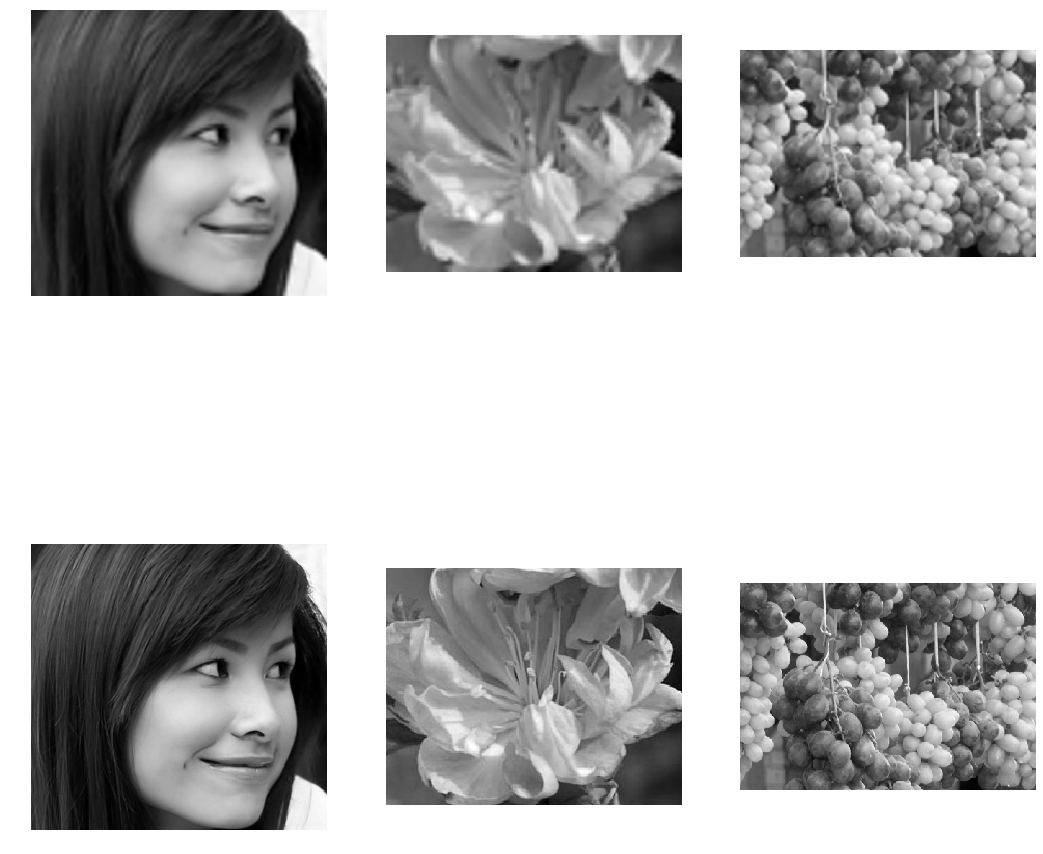

sub_image_set:
90/91 [============================>.] - ETA: 0s
load_set: 
10/14 [====================>.........] - ETA: 0s
sub_image_set:
13/14 [==========================>...] - ETA: 0s


In [14]:
""" 
     _______________________________________________
    | YOU SHOULD NOT CHANGE ANY THING IN THIS CELL. |
    |_______________________________________________|
"""
dataset = Dataset()

# load tranning dataset
dataset.load_set(train_dataset_dir, same_size, greyscale)
dataset.show_set()
if randomly_crop:
  train_lr, train_hr = dataset.sub_image_set_random(size, training_output_size, scale, number_of_image)
else:
  train_lr, train_hr = dataset.sub_image_set(size, training_output_size, stride, scale)

# make tf.data dataset
train_dataset = tf.data.Dataset.from_tensor_slices((train_lr, train_hr))
train_dataset = train_dataset.batch(train_batch)
train_dataset = train_dataset.repeat()

# load validation dataset
dataset.clear_set()
dataset.load_set(val_dataset_dir, same_size, greyscale)
if randomly_crop:
  val_lr, val_hr = dataset.sub_image_set_random(size, training_output_size, scale, number_of_image)
else:
  val_lr, val_hr = dataset.sub_image_set(size, training_output_size, stride, scale)

# make tf.data dataset
val_dataset = tf.data.Dataset.from_tensor_slices((val_lr, val_hr))
val_dataset = val_dataset.batch(val_batch)
val_dataset = val_dataset.repeat()

In [15]:
""" 
    _________
    | Train |
    ————-
     _______________________________________________
    | YOU SHOULD NOT CHANGE ANY THING IN THIS CELL. |
    |_______________________________________________|
"""
model = model_class.build_model([size, size], training_padding)

# print model details below
print("Model Name: {}".format(model.name))
model.summary()

train(model, train_dataset, val_dataset, epochs, train_steps, val_steps, resume)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Model Name: srcnn
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        5248      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        2080      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 1)         801       
Total params: 8,129
Trainable params: 8,129
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.cast instead.


KeyboardInterrupt: ignored

In [0]:
""" 
     _______________________________________________
    | YOU SHOULD NOT CHANGE ANY THING IN THIS CELL. |
    |_______________________________________________|
"""
dataset = Dataset()

# load test dataset
dataset.load_set(test_dataset_dir, same_size, greyscale)
dataset.show_set()
if randomly_crop:
  test_lr, test_hr = dataset.sub_image_set_random(size, test_output_size, scale, number_of_image)
else:
  test_lr, test_hr = dataset.sub_image_set(size, test_output_size, stride, scale)

# make tf.data dataset
test_dataset = tf.data.Dataset.from_tensor_slices((test_lr, test_hr))
test_dataset = test_dataset.batch(test_batch)
test_dataset = test_dataset.repeat()

In [0]:
""" 
    _________
    | Test  |
    ---------
     _______________________________________________
    | YOU SHOULD NOT CHANGE ANY THING IN THIS CELL. |
    |_______________________________________________|
"""
model = model_class.build_model([size, size], test_padding)

# print model details below
print("Model Name: {}".format(model.name))
model.summary()

test(model, test_dataset, steps=test_steps, metrics=None)

In [0]:
""" 
    _________
    | Demo  |
    ---------
"""
result_demo('Set5', model_class, same_size, greyscale)

In [0]:
""" 
    _______________
    | Prediction  |
    ---------------
     _______________________________________________
    | YOU SHOULD NOT CHANGE ANY THING IN THIS CELL. |
    |_______________________________________________|
"""
predict(model_class, greyscale)